In [ ]:
import pandas as pd
import numpy as np

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import re
import os

import spacy

from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
from tqdm.notebook import tqdm
tqdm.pandas()

В этом блоке кода происходит подготовка *инструментов* для *обработки текста* (загрузка леммизатора, стоп-слов, классов ответов)

In [ ]:
#===============================================================================
# Загрузка моделей
#===============================================================================
lemmatizer = spacy.load('ru_core_news_md', disable = ['parser', 'ner'])

with open("model/stopwords.txt") as f: stopwords_nltk = f.read().splitlines()

tfidf = joblib.load('model/tfidf.pkl')

#===============================================================================
# Загрузка данных
#===============================================================================

# классы с ответами
train_answer_class = pd.read_csv('model/answer_class.csv', sep=',', index_col=None)

# классы с эмбедингами вопросов
train = joblib.load('model/train.pkl')

# извлечение эмбедингов и классов
tfidf_embed = train['tfidf_embed']
classes = train['classes']

# словарь перевода классов в группы
label_dist = {0: 'Документы',
             1: 'Документы',
             2: 'Документы',
             3: 'Документы',
             4: 'Документы',
             5: 'Организация уроков',
             6: 'Организация уроков',
             7: 'Организация уроков',
             8: 'Организация уроков',
             9: 'Организация уроков',
             10: 'Оценки',
             11: 'Перевод/ запись в группу',
             12: 'Практические работы',
             13: 'Программа обучения',
             14: 'Портал',
             15: 'Портал',
             16: 'Портал',
             17: 'Портал',
             18: 'Портал',
             19: 'Программа обучения',
             20: 'Программа обучения',
             21: 'Расписание',
             22: 'Расписание',
             23: 'Требования ПО',
             24: 'Требования ПО',
             25: 'Трудоустройство',
             26: 'Трудоустройство',
             27: 'Трудоустройство',
             28: 'Документы',
             29: 'Документы',
             30: 'Переключить на оператора',
             }
# предел схожести, при котором отдаем ответ
lim_similarities = 0.4

В этом блоке кода мы преобразуем **исходный текст** в **удобный для языковой модели** текст:

In [ ]:
#===============================================================================
# Работа с текстом
#===============================================================================

# очистка текста
def full_clean(text):
    '''подготовка текста к подаче в модель для каждого текста (через applay)'''
    text=re.sub(r"[^a-zA-Zа-яА-ЯёЁ0-9#]", " ", text)
    text = text.lower()
    text = re.sub(" +", " ", text) # оставляем только 1 пробел
    text = text.strip()
    # токены для моделей
    tokens = [token.lemma_ for token in lemmatizer(text) if token.lemma_ not in stopwords_nltk]
    # для tfidf на вход текст
    text = " ".join(tokens)
    return text, tokens


def tfidf_embeding(model=None, df=None):
    '''Преобразование текста в мешок слов'''
    if model==None:
        #загрузить если нет
        model = joblib.load('tfidf.pkl')
    else:
        model=model
    X = model.transform(df)

    return X.toarray()

Далее, уже преобразованный текст подвергается **числовой векторизации**, благодаря которой возможно дальнейшее предсказание *класса ответа*

In [ ]:
#===============================================================================
# Поиск схожих векторов и предсказание класса ответа
#===============================================================================

def find_similarity(query, embeddings, classes, top_k=2):
    # самые близкие вопросы из трейна
    # возвращает класс, категорию, схожесть
    query_embedding = tfidf_embeding(model=tfidf, df=[full_clean(query)[0]])[0]
    cos_similarities = cosine_similarity(query_embedding.reshape(1, -1), np.array(embeddings))
    sorted_indices = np.argsort(cos_similarities[0])[::-1]
    top_class = [classes[idx] for i, idx in enumerate(sorted_indices[0:top_k])]

    # для предикта класса 30 не существует
    if top_class[0] == 30:
        top_class[0] = top_class[1]

    return top_class[0], label_dist[top_class[0]], cos_similarities[0][sorted_indices[0]]

def predict(query):
    # главная функция
    answer_class, category, similarity = find_similarity(query, tfidf_embed, classes, top_k=2)
    answer = train_answer_class[train_answer_class.answer_class==answer_class]['Answer'].values[0]

    return answer_class, category, answer, round(similarity, 2)

In [ ]:
# две колонки, без индекса, разделитель запятая
submission = pd.read_csv('train_SecondPilot/sample_submission.csv', sep=',', index_col=None)
submission.head()

,hash,answer_class
0,-5619544560237527616,0
1,-3561821032679218920,0
2,5542832344828775180,0
3,374064106604922467,0
4,7767274468230729980,0


In [ ]:
test = pd.read_csv('data/my_test.csv', sep=',', index_col=None)
test.head()

,hash,Question
0,"-5,61954456023753E+018",На какие специальности можно поступить у вас?
1,"-3,56182103267922E+018",Где посмотреть всю информацию по моему курсу?
2,"5,54283234482878E+018",Расскажите про налоговые вычеты.
3,"3,74064106604922E+017",Какие документы нужны для поступления?
4,"7,76727446823073E+018",Получу ли я бумажный сертификат после прохожде...


Здесь мы **сохраняем** список вопросов из расположенной выше таблицы *(представлен лишь её фрагмент)*

In [ ]:
texts = test['Question'].tolist()

Составляем *классы вопросов* на основе **натренированной модели**:

In [ ]:
def predict_tfidf(texts):
    predicts = []
    for text in tqdm(texts):
        answer_class, category, answer, similarity = predict(text)
        predicts.append(answer_class)
    return predicts

In [ ]:
predicts = predict_tfidf(texts)
test['answer_class'] = predicts

  0%|          | 0/10 [00:00<?, ?it/s]

**Сохраняем** полученные результаты в файл:

In [ ]:
#сохраним сабмит
test[['hash', 'answer_class']].to_csv('submission/submission1.csv', sep=',', index=False)

Получаем **классы** с помощью *предсказательной модели* в **отложенной выборке**:

In [ ]:
hold = pd.read_csv('data/hold_data.csv', sep=',', index_col=None)
hold.head()

,Question,Category,answer_class
0,Получу ли я диплом государственного образца по...,Документы,0
1,Что я получу если сдам все экзамены?,Документы,0
2,"Если я не сдам один экзамен, могу ли я получит...",Документы,1
3,Как оцениваются компетенции?,Документы,1
4,"Если я еще учусь в университете, могу я получи...",Документы,2


In [ ]:
texts = hold['Question'].tolist()

In [ ]:
predicts = predict_tfidf(texts)

  0%|          | 0/60 [00:00<?, ?it/s]

Оцениваем *производительность* предсказательной модели классификации:

In [ ]:
test_labels = hold['answer_class'].tolist()

In [ ]:
print(classification_report(test_labels, predicts))
print(f1_score(test_labels, predicts, average='micro'))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.50      0.50      0.50         2
           2       0.50      0.50      0.50         2
           3       0.50      0.50      0.50         2
           4       1.00      0.50      0.67         2
           5       0.00      0.00      0.00         2
           6       0.50      1.00      0.67         2
           7       0.50      0.50      0.50         2
           8       0.50      0.50      0.50         2
           9       1.00      1.00      1.00         2
          10       0.50      1.00      0.67         2
          11       1.00      1.00      1.00         2
          12       1.00      0.50      0.67         2
          13       0.33      0.50      0.40         2
          14       0.33      0.50      0.40         2
          15       1.00      1.00      1.00         2
          16       0.67      1.00      0.80         2
          17       1.00    

/home/tanya/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tanya/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tanya/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(0.5, 0.98, 'Plot of confusion matrix')

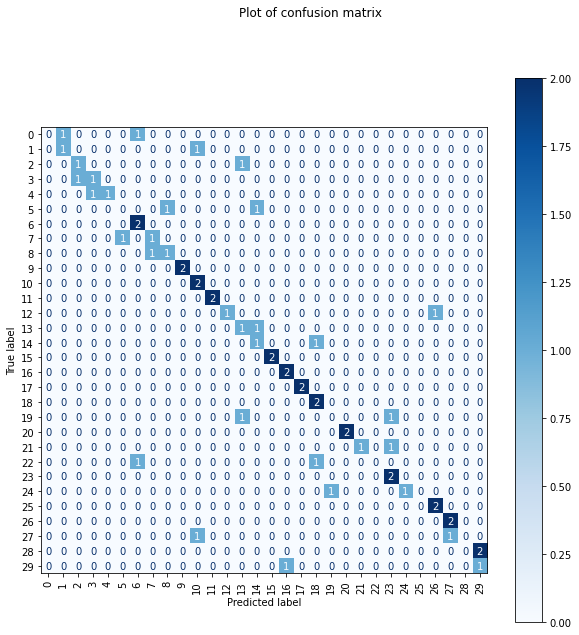

In [ ]:
cmp = ConfusionMatrixDisplay.from_predictions(test_labels, predicts, xticks_rotation = 'vertical', cmap=plt.cm.Blues)
fig = cmp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)
fig.suptitle('Plot of confusion matrix')

**Предсказание бертом**

In [ ]:
from datasets import Dataset
import datasets
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer

2024-04-27 21:08:08.601246: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 21:08:09.264565: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
model_name = 'bert-base-multilingual-uncased'

tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
max_length = 24

In [ ]:
# для теста и отложенного датасета
def preprocess_test(examples):
    # Берём пакеты text-ов
    text = examples['Question']
    # кодируем их
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=max_length)

    return encoding

def encoding_test(df_test):
    # подготовка датасета для модели
    test_dataset = Dataset.from_pandas(df_test)
    dataset = datasets.DatasetDict({"test":test_dataset})

    encoded_dataset = dataset.map(preprocess_test, batched=True, remove_columns=dataset['test'].column_names)
    encoded_dataset.set_format("torch")

    return encoded_dataset

Загрузка **сохраненной модели** для проверки:

In [ ]:
save_directory = 'model/checkpoint-bert'
best_model = BertForSequenceClassification.from_pretrained(save_directory, local_files_only=True)

In [ ]:
trainer1 = Trainer(best_model)

In [ ]:
def get_prediction(dataset):
    # предсказание для проверки загрузки сохраненной модели
    pred = trainer1.predict(dataset)
    labels = np.argmax(pred.predictions, axis = -1)
    return labels

In [ ]:
test_dataset = encoding_test(test[['Question']])

  0%|          | 0/1 [00:00<?, ?ba/s]

*Предсказываем класс* на основе "закодированных" ранее вопросов:

In [ ]:
# предсказание
pred = get_prediction(test_dataset['test'])
test['answer_class']=pred

In [ ]:
test[['hash', 'answer_class']].to_csv('submission/submission2.csv', sep=',', index=False)

Проверяем **итоговый результат** работы предсказательной модели:

In [ ]:
test

,hash,Question,answer_class
0,"-5,61954456023753E+018",На какие специальности можно поступить у вас?,19
1,"-3,56182103267922E+018",Где посмотреть всю информацию по моему курсу?,18
2,"5,54283234482878E+018",Расскажите про налоговые вычеты.,28
3,"3,74064106604922E+017",Какие документы нужны для поступления?,2
4,"7,76727446823073E+018",Получу ли я бумажный сертификат после прохожде...,4
5,"1,7662125181686E+018",Кто куратор моего курса?,14
6,"-6,58868589443032E+018",Гарантировано ли трудоустройство после ваших к...,27
7,"-7,16979383993187E+018",Бесплатно ли высылаются документы о прохождени...,3
8,"5,00750939243659E+018",По какому адресу можно узнать подробности моег...,14
9,"1,68021103355415E+018",Когда начнутся занятия?,5
